In [1]:
#%matplotlib widget
import matplotlib.pyplot as plt
FileName='data_withbkg-36gain.img'

[Application],Enconding=UTF-8,Date="1/12/2024",Time="5:31:49 PM.041",Software="HPD-TA",Application=2,ApplicationTitle="High Performance Digital Temporal Analyzer",SoftwareVersion="9.5 pf11",SoftwareDate="01.07.2021"
[Camera],CameraName="C13440-20C",SerialNumber="S/N: 306629",DCAMAPIVERSION="4.00",BUS="AS-FBD-1XCLD-2PE4L",VENDOR="Hamamatsu",CAMERAVERSION="4.31.C",DRIVERVERSION="8.13.30.6307",MODULEVERSION="21.7.4322.6307",Type=34,Binning="1",BinningKeyVal="2 x 2",ScanMode="2",ScanModeKeyVal="Subarray",HOffs="176",HWidth="672",VOffs="258",VWidth="508",TriggerMode="3",TriggerModeKeyVal="Internal",TriggerPolarity="1",TriggerPolarityKeyVal="neg.",ScanSpeed="2",Prop_SensorMode=1,Prop_ReadoutDirection=5,Prop_Colortype=1,Prop_BitPerChannel=16,Prop_TriggerGlobalExposure=5,Prop_TriggerConnector=2,Prop_TriggerTimes=1,Prop_TriggerDelay=0,Prop_InternalTriggerHandling=1,Prop_SensorCoolerStatus=2,Prop_DefectCorrectMode=2,Prop_HotPixelCorrectLevel=1,Prop_IntensityLutMode=1,Prop_IntensityLutPage=1,Prop

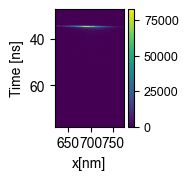

In [2]:
import numpy as np


import matplotlib as mat
import os
cms=1/2.54

########################
#Parameter
########################

BkgFileName='databkg.img'#change if bkg exist
verbose=True



########################
#Load and parse the file
########################
file=open(FileName,mode='rb')
data_raw=file.read()
IndexDataStart=np.frombuffer(data_raw[2:4], dtype=np.dtype('u2'))[0]+64

if verbose==True:
    print(data_raw[64:IndexDataStart].decode())

########################
#Recover image basic parameter
########################
BitDepth=np.frombuffer(data_raw[12:13], dtype=np.dtype('u1'))
BytesPerPixel=int(data_raw[data_raw.find(b'BytesPerPixel')+14: \
                                      data_raw.find(b'BytesPerPixel')+15].decode())

#It can't be that there is more than 2048 pixel which should then show as as 4 char
#so we split to only slect the right amount of character
ImgWidth=int(data_raw[data_raw.find(b'HWidth')+8: \
                                      data_raw.find(b'HWidth')+13].decode().split('"')[0])
ImgHeight=int(data_raw[data_raw.find(b'VWidth')+8: \
                                      data_raw.find(b'VWidth')+13].decode().split('"')[0])

IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart


print('Shape of image (widht x height): {}x{} px'.format(ImgWidth,ImgHeight))


########################
#Recover the unit for the different axis
########################

TimeUnit=data_raw[data_raw.find(b'ScalingYUnit'): \
                                      data_raw.find(b'ScalingYUnit')+18].decode().split('"')
XUnit=data_raw[data_raw.find(b'ScalingXUnit'): \
                                      data_raw.find(b'ScalingXUnit')+18].decode().split('"')

if TimeUnit[1]=='' :
    Time=np.linspace(-1,1,ImgHeight)
    TimeUnit[1]='a.u'
if XUnit[1]=='':
    x=np.linspace(-1,1,ImgWidth)
    XUnit[1]='a.u'
elif TimeUnit[1]=='a.u'  and XUnit[1]!='':
    print('a')
    x=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
elif TimeUnit[1]!='' and XUnit[1]!='':
    print('b')
    temp=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
    x=temp[0:ImgWidth]
    Time=temp[ImgWidth:]



########################
#Finally load the data
########################

if BytesPerPixel==4:
    Data= np.reshape(np.frombuffer(data_raw[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
elif BytesPerPixel==2:
    Data= np.reshape(np.frombuffer(data_raw[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))

if os.path.isfile(BkgFileName):
    file=open(BkgFileName,mode='rb')
    data_raw_bkg=file.read()
    if BytesPerPixel==4:
        Databkg= np.reshape(np.frombuffer(data_raw_bkg[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
    elif BytesPerPixel==2:
        Databkg= np.reshape(np.frombuffer(data_raw_bkg[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))
    Data=Data-Databkg

########################
#Fianlly we plot the data
########################

fig=plt.figure(figsize=(5*cms,5*cms))
ax0 =plt.subplot(1,1,1)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})
im=ax0.pcolormesh(x,Time,Data)

ax0.set_ylabel('Time [{}]'.format(TimeUnit[1]))
ax0.set_xlabel('x[{}]'.format(XUnit[1]))
ax0.invert_yaxis()
fig.colorbar(im)
plt.tight_layout()
print(np.max(Data))



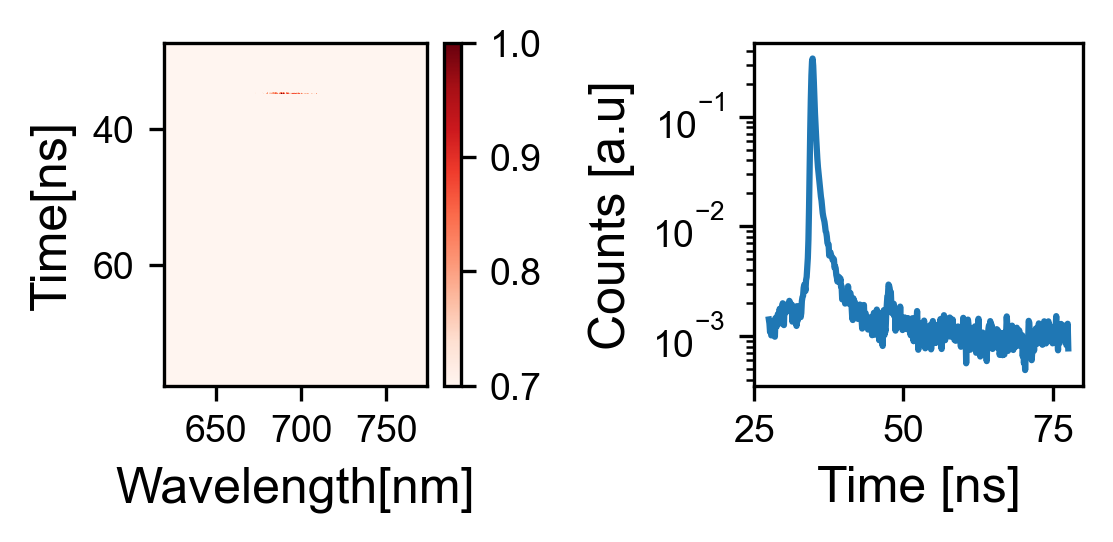

In [3]:
import glob
from scipy.signal import savgol_filter
c='plasma'
cms=1/2.54
fig1=plt.figure(figsize=(10*cms,5*cms))
ax1 =plt.subplot(1,2,1)
#ax2 =plt.subplot(1,3,2)
ax3 =plt.subplot(1,2,2)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

im2=ax1.pcolormesh(x,Time,Data/np.max(Data),cmap='Reds',vmin=0.7,vmax=1)
ax1.set_ylabel('Time [{}]'.format(TimeUnit[1]))
ax1.set_xlabel('x[{}]'.format(XUnit[1]))
ax1.invert_yaxis()
plt.colorbar(im2,ax=ax1)


#Now we only look for the maximum value
wmax=np.unravel_index(Data[:,:].argmax(), Data[:,:].shape)[1]
ax3.plot(Time,np.mean(Data[:,:]/np.max(Data[:,:]),1))

ax1.set_ylabel('Time[ns]', wrap=True)
ax1.set_xlabel('Wavelength[nm]')

ax3.set_ylabel('Counts [a.u]', wrap=True)
ax3.set_xlabel('Time [ns]')
ax3.set_yscale('log')
plt.tight_layout()
plt.savefig("Data.png")



# Fitting  lifetime
## Single wavelength

[0.33704818 0.16778574]
[2.29588865 0.11731831 0.17836044 1.08542522]


d:\Python\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


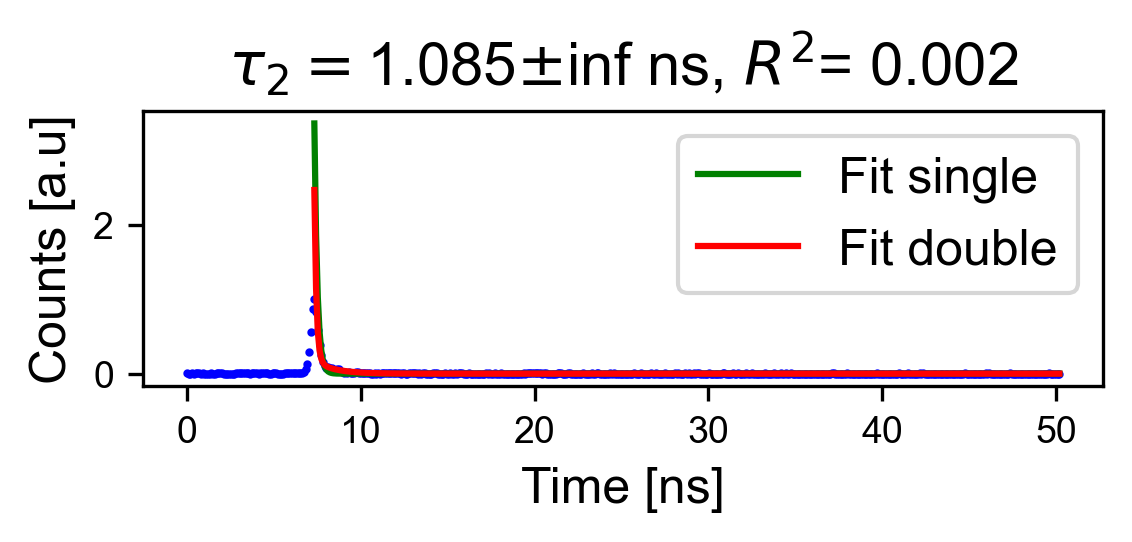

In [4]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare

ScalingParameter=[10,1,1,2]
########################
#Plotting
########################
cms=1/2.54
fig1=plt.figure(figsize=(10*cms,5*cms))
ax1 =plt.subplot(1,1,1)


mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})



def TriexpFunc(x,a,b,c,d,e,f):
    return np.array(a*ScalingParameter[0] * np.exp( -(x/(b*ScalingParameter[1]))) +
                    c*ScalingParameter[2] * np.exp( -(x/(d*ScalingParameter[3])))+
                    e*ScalingParameter[4] * np.exp( -(x/(f*ScalingParameter[5]))),dtype='float32')

def BiexpFunc(x,a,b,c,d):
    return np.array(a*ScalingParameter[0] * np.exp( -(x/(b*ScalingParameter[1]))) +
                    c*ScalingParameter[2] * np.exp( -(x/(d*ScalingParameter[3]))),dtype='float32')

def expFunc(x,a,b):
    return np.array(a*ScalingParameter[0] * np.exp(-(x/(b*ScalingParameter[1]))),dtype='float32') 

def IRFGaussian(x,b,c):
	return np.array((1/(c*np.sqrt(2*np.pi)))*np.exp(-0.5*np.power((x-b)/(c),2)),dtype='float32')
 
data=np.mean(Data[:,wmax-1:wmax+1],1)
index_max=data.tolist().index(max(data))

Time_fit=Time[index_max:]-Time[index_max]
Data_fit=(data[index_max:]-np.min(data))
Data_fit=Data_fit/np.max(Data_fit)
Data_plot=(data-np.min(data))
Data_plot=Data_plot/np.max(Data_plot)

########################
#Exp fit
########################

popt, pcov = curve_fit(expFunc,Time_fit,Data_fit)
curveye = expFunc(Time_fit,popt[0],popt[1]) # This is your y axis fit-line
print(popt)
########################
#Bi exp fit
########################

popt, pcov = curve_fit(BiexpFunc,Time_fit,Data_fit,p0=[popt[0],popt[1],1,2.5])
print(popt*ScalingParameter)
curvey = BiexpFunc(Time_fit,popt[0],popt[1],popt[2],popt[3]) # This is your y axis fit-line
LifeTimeError=np.sqrt(np.diag(pcov)[3]*ScalingParameter[3])


Rsq=1-(np.sum(np.power(Data_fit-curvey,2)))/(np.sum(np.power(Data_fit-np.mean(Data_fit),2)))

ax1.plot(Time_fit+Time[index_max]-np.min(Time), curveye, 'green', label='Fit single')
ax1.plot(Time_fit+Time[index_max]-np.min(Time), curvey, 'red', label='Fit double')
ax1.scatter(Time-np.min(Time),Data_plot, c='b',s=1)


ax1.set_title('$\\tau _2=${}$\pm${} ns, $R^2$= {}'.format(
    str(np.round(popt[3]*ScalingParameter[3],decimals=3)),np.round(LifeTimeError,decimals=3),np.round(Rsq,decimals=3)))
ax1.set_ylabel('Counts [a.u]', wrap=True)
ax1.set_xlabel('Time [ns]')
ax1.legend()
#ax1.set_yscale('log')
plt.tight_layout()
plt.savefig("Fit.png")

## Fitting lifetime for all wavelength 

In this specific part we fit a double exponential and take the slow component (i.e the second one) as the lifetime.

In [5]:
from scipy.optimize import differential_evolution

DegreeExponential=2
def MultiExponentialFunction(para,data):
	taui, fi = np.split(para, 2)
	x=data[0]
	y=data[1]
	return np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2)

def MultiExponentialFunctionRsq(para,data):
	taui, fi = np.split(para, 2)
	x=data[0]
	y=data[1]
	return 1-np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2)/np.sum((y-np.mean(y))**2)

Time_max_index=np.unravel_index(data.argmax(), data.shape)[0]
Time_fit=Time[Time_max_index:]-np.min(Time[Time_max_index])

nb_wave=Data.shape[1]
Data_fit_s=np.empty([len(x),Time_fit.shape[0]])
lifetime=np.empty(nb_wave)
gof=np.empty(nb_wave)

for idx in range(3,nb_wave-3):
    data=np.mean(Data[:,idx-1:idx+1],1)

    Data_fit=(data[Time_max_index:]-np.min(data))/np.max(data[Time_max_index:]-np.min(data)) 
    bounds = [[min(Time_fit), max(Time_fit)]]*DegreeExponential + [[min(Data_fit), max(Data_fit)]]*DegreeExponential
    

    try:
        result = differential_evolution(func=MultiExponentialFunction,bounds=bounds,args=((Time_fit,Data_fit),))
        s = result['x']
        tau_fit,Coeff_fit=np.split(s,2)

        gof[idx] = MultiExponentialFunctionRsq(s,(Time_fit,Data_fit))
        Data_fit_s[idx,:]=np.interp(Time_fit,Time_fit,np.dot(Coeff_fit, np.exp(-np.outer(1./tau_fit, Time_fit))))
        if gof[idx]>0.95:
            lifetime[idx]=tau_fit[1]
        else:
             lifetime[idx]=None
    except RuntimeError:
        print('Could not fit')
        continue


C:\Users\gautier\AppData\Local\Temp\ipykernel_3500\1798841312.py:8: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2)
d:\Python\Lib\site-packages\numpy\core\numeric.py:943: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


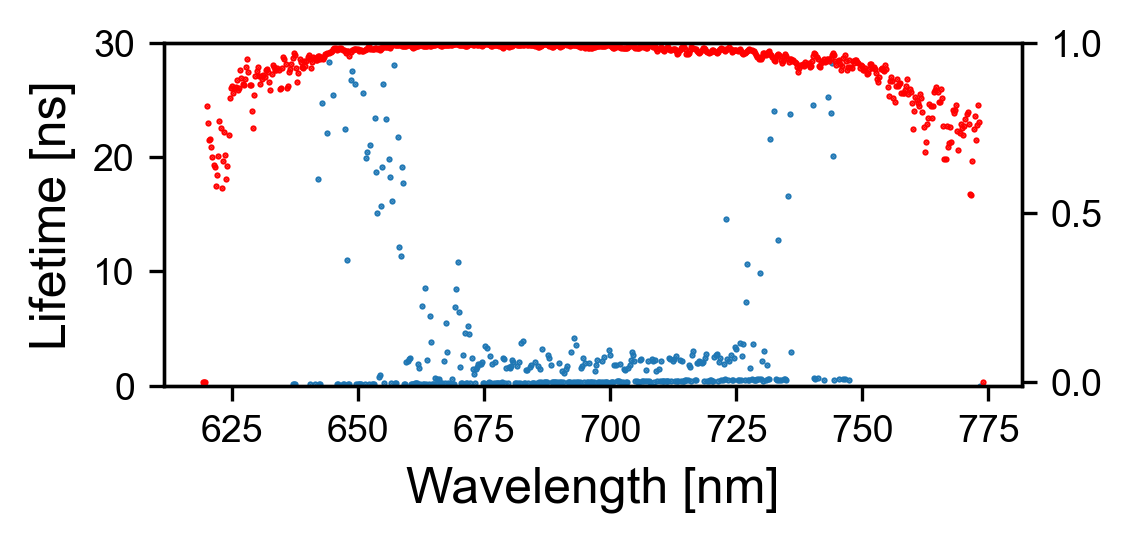

In [6]:
if 'fig1' in locals():
    try:
        del fig1,ax1,ax2
    except NameError:
        pass

fig1=plt.figure(figsize=(10*cms,5*cms))
ax1 =plt.subplot(1,1,1)
ax2 =ax1.twinx() 

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})
lifetime_c=lifetime
lifetime_c[lifetime<0]=-100
ax1.plot(x,lifetime_c,'.',markersize=1)


ax1.set_ylim([0,30])
ax1.set_ylabel('Lifetime [ns]', wrap=True)
ax1.set_xlabel('Wavelength [nm]')


ax2.plot(x,gof,'.',color='red',markersize=1)
ax2.set_ylim([-0.01,1])
ax2.set_xlabel('$R^2$ [a.u]', wrap=True)

plt.tight_layout()
plt.savefig("LifevsWave.png")


# Beauty shot TRPL

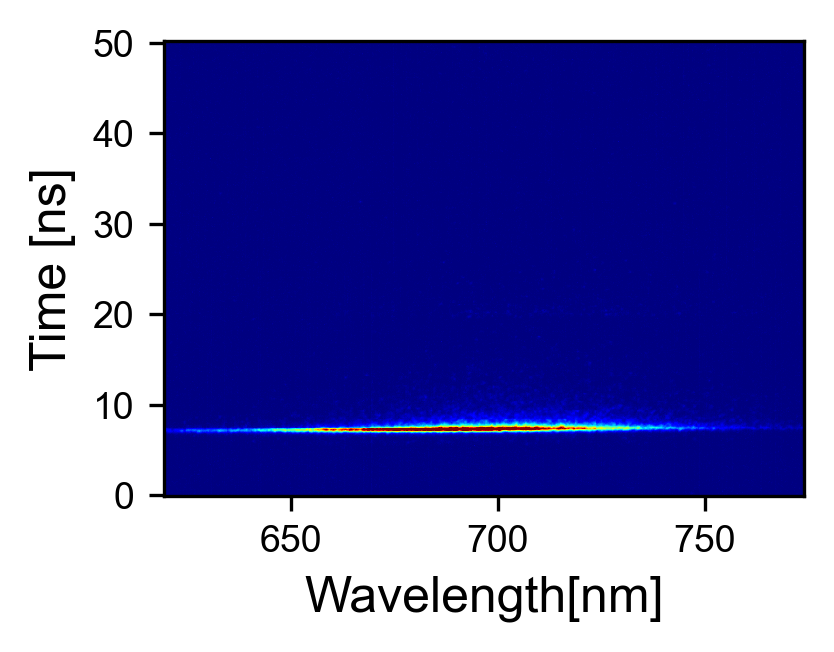

In [7]:
data=np.zeros(Data.shape)
import pandas as pd
import scipy.ndimage as ndimage

data=pd.DataFrame(Data)
#for idx in range(0,Data.shape[0]):
#    data[idx,:]=savgol_filter(Data[idx,:], 6, 2)
temp=ndimage.gaussian_filter(data,sigma=(0,3))
temp=data
fig1=plt.figure(figsize=(7*cms,5*cms))
ax1 =plt.subplot(1,1,1)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

im2=ax1.pcolormesh(x,Time-min(Time),temp,cmap='jet',vmin=0, vmax=45000)
ax1.set_ylabel('Time [{}]'.format(TimeUnit[1]))
ax1.set_xlabel('Wavelength[{}]'.format(XUnit[1]))
plt.savefig("RawLifetimeGaussianFilter.png")

# Follow kinetics

## Load the data

In [9]:
import glob
import scipy.ndimage as ndimage
Folder='./'
DataNameBasis='/'

File=glob.glob(Folder+DataNameBasis+"*.img")
Data_kin=np.zeros([len(File),ImgHeight,ImgWidth])
Data_gif=np.zeros([len(File),ImgHeight,ImgWidth])
TimeExp=np.zeros([len(File),1])
images = []

for i,File_temp in enumerate(File):
    file=open(File_temp,mode='rb')
    data_raw_kin=file.read()
    IndexDataStart=np.frombuffer(data_raw_kin[2:4], dtype=np.dtype('u2'))[0]+64
    IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart
    
    TimeTemp=data_raw_kin[data_raw_kin.find(b'Time'): \
                                      data_raw_kin.find(b'Time')+16].decode().split('"')
    #print(TimeTemp)
    try:
        TimeExp[i]=int(TimeTemp[1].split(':')[0])*3600+int(TimeTemp[1].split(':')[1])*60+int(TimeTemp[1].split(':')[2][:2])
    except:
        if i==1:
            TimeExp[0]=0
        TimeExp[i]=float(TimeTemp[1].split('ms')[0])
    if BytesPerPixel==4:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
    elif BytesPerPixel==2:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))
    Data_kin[i,:,:]=temp
    Data_gif[i,:,:]=ndimage.gaussian_filter( np.squeeze(Data_kin[i,:,:]),sigma=(0,3))

TimeExp=np.round(TimeExp-TimeExp[0],0)/1000

## Create a gif of the kinetics

MovieWriter ffmpeg unavailable; using Pillow instead.


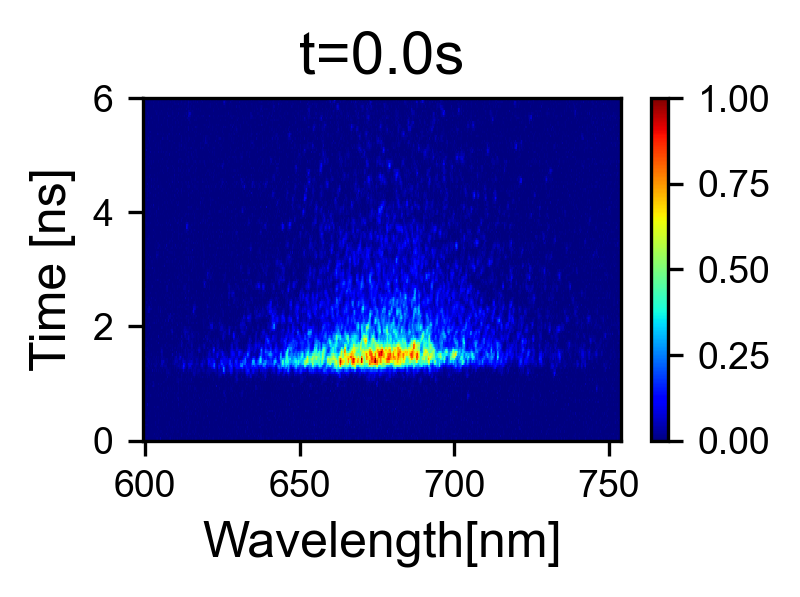

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
fig1=plt.figure(figsize=(7*cms,5*cms))
ax1 =plt.subplot(1,1,1)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

maxI0=np.max(Data_kin[0,:,:])
im2=ax1.pcolormesh(x,Time-min(Time),Data_kin[0,:,:]/maxI0,cmap='jet',vmin=0, vmax=1)
ax1.set_ylabel('Time [{}]'.format(TimeUnit[1]))
ax1.set_xlabel('Wavelength[{}]'.format(XUnit[1]))
ax1.set_ylim([0,6])
plt.colorbar(im2,ax=ax1)
plt.tight_layout()

def animate(i):
    ax1.set_title('t={}s'.format(TimeExp[i].squeeze())) 
    im2.set_array((Data_kin[i,:,:]/maxI0))

ani = animation.FuncAnimation(fig1, animate, interval=100, frames=50) 
ani.save("Lifetime.gif")

## Follow the kinetics (Bi-exponential Fit)

IntProgress(value=0, max=0)

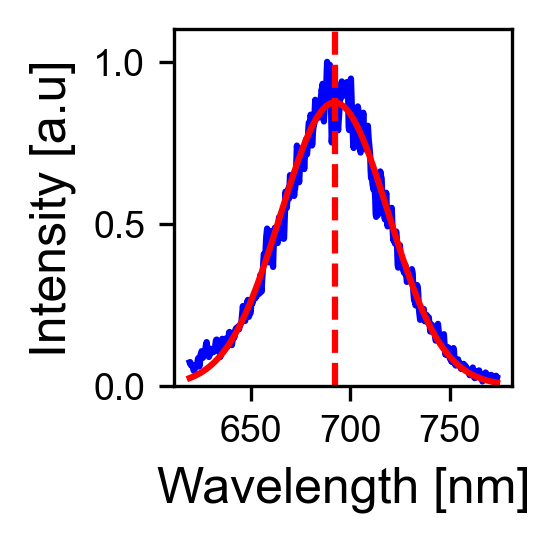

In [18]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import pandas as pd
from ipywidgets import IntProgress
from IPython.display import display

max_count = len(File[:-1])

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

#ScalingParameter=[0.1,1,0.1,1,0.01,1,0.001,1]
ScalingParameterG=[1,100,10]
R_value=0.90

DegreeExponential=2
def MultiExponentialFunction(para,data):
	taui, fi = np.split(para, 2)
	x=data[0]
	y=data[1]
	return np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2)

def MultiExponentialFunctionRsq(para,data):
	taui, fi = np.split(para, 2)
	x=data[0]
	y=data[1]
	return 1-np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2)/np.sum((y-np.mean(y))**2)
'''
def BiexpFunc(x,a,b,c,d):
    return np.array(a*ScalingParameter[0] * np.exp( -(x/(b*ScalingParameter[1]))) +
                    c*ScalingParameter[2] * np.exp( -(x/(d*ScalingParameter[3]))),dtype='float32')'''
def BiexpFunc(x,a,b,c,d):
    return np.array(a * np.exp( -(x/(b))) +c * np.exp( -(x/(d))),dtype='float32')

def Gaussian(x,a,b,c):
	return np.array(a*ScalingParameterG[0] * np.exp(-0.5*np.power((x-b*ScalingParameterG[1])/(c*ScalingParameterG[2]),2)),dtype='float32') 





Time_interp=np.linspace(0,(np.max(Time)-np.min(Time))*0.8,num=1000)


Data_fit_s=np.empty([len(File),Time_interp.shape[0]])
Data_exp_s=np.empty([len(File),Time_interp.shape[0]])
Rsq_Overfit=np.empty(len(File))

LifetimePeak=np.empty(len(File))
ErrorLifetimePeak=np.empty(len(File))

WavePeak=np.empty(len(File))
Max_int_Theoritical=np.empty(len(File))
Max_int=np.empty(len(File))

Rsq_kin=np.empty(len(File))

FittedLifetimeTrace=pd.DataFrame(np.empty([len(File),len(Time)]))

fig1=plt.figure(figsize=(5*cms,5*cms))
ax1 =plt.subplot(1,1,1)


mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

# dim= [exp, time wave]
for i,File_temp in enumerate(File):
	f.value+=1
	Time_max_index=np.unravel_index(Data_kin[i,:,:].argmax(), Data_kin[i,:,:].shape)[0]
	#First we try to fit to a gaussian to find the center of the peak 
	data_temp_kin=np.squeeze(np.mean(Data_kin[i,Time_max_index-5:Time_max_index+5,:]
								  -np.min(Data_kin[i,Time_max_index-5:Time_max_index+5,:]),0))
	if i==0:
		IntNorma=np.max(data_temp_kin)
	try:
		########################
		#Gaussian fit
		########################

		popt, pcov = curve_fit(Gaussian,x,data_temp_kin/IntNorma,p0=[1,7.00,5.0])
		curvey = Gaussian(x,popt[0],popt[1],popt[2])


		Max_int_Theoritical[i]=np.max(curvey)
		Max_int[i]=np.max(Data_fit)
		WavePeak[i]=popt[1]*ScalingParameterG[1]

		if i ==0:
			ax1.set_ylim([0,1.1])
			ax1.plot(x,data_temp_kin/IntNorma,color='b',label='Exp. Data')
			ax1.plot(x,curvey,color='r',label='Fit')
			ax1.plot([WavePeak[0],WavePeak[0]],ax1.get_ylim(),'--',color='r')
	except RuntimeError:
		print('Could not fit')
		continue
	except ValueError:
		continue

	# We now take a slice in time at the theoritical maximum and try to fit a biexponential to it
	if (WavePeak[i] <x[-1]) or (WavePeak[i]>x[0]):
		print(WavePeak)
		continue

	temp=np.squeeze(Data_kin[i,:,np.abs(x-WavePeak[i]).argmin()-5:np.abs(x-WavePeak[i]).argmin()+5])
	data_temp_kin=np.squeeze((np.mean(temp,1)-np.min(np.mean(temp,1)))
						  /np.max(np.mean(temp,1)-np.min(np.mean(temp,1))))

	index_max=data_temp_kin.tolist().index(max(data_temp_kin))


	Time_fit=Time[index_max:]-np.min(Time[index_max])
	Data_fit=data_temp_kin[index_max:]
	
	bounds = ([[min(Time_fit), max(Time_fit)]]*DegreeExponential
		   +[[min(Data_fit), max(Data_fit)]]*DegreeExponential)
    
	try:

		result = differential_evolution(func=MultiExponentialFunction,bounds=bounds,
										args=((Time_fit,Data_fit),))
		s = result['x']
		tau_fit,Coeff_fit=np.split(s,2)

		popt, pcov = curve_fit(BiexpFunc,Time_fit,Data_fit,
						 p0=[Coeff_fit[0],tau_fit[0],Coeff_fit[1],tau_fit[1]])
		Rsq_kin[i]=MultiExponentialFunctionRsq(np.array([popt[1],popt[3],popt[0],popt[2]]),(Time_fit,Data_fit))
		

		if popt[3]>0:
			LifetimePeak[i]=popt[3]
			ErrorLifetimePeak[i]=np.sqrt(np.diag(pcov)[3])
			Data_exp_s[i,:]=np.interp(Time_interp,Time_fit,Data_fit)
			Data_fit_s[i,:]=BiexpFunc(Time_interp,popt[0],popt[1],popt[2],popt[3])
			
		if Rsq_kin[i]<R_value:
			LifetimePeak[i]=None
			ErrorLifetimePeak[i]=None
	except RuntimeError:
		print('Could not fit')
		LifetimePeak[i]=None
		ErrorLifetimePeak[i]=None
		continue
	except Exception as e:
		print(e)
		continue
		
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Intensity [a.u]')
plt.tight_layout()
plt.savefig('GaussianFitInt.png')


## Interactive tool to check the different fit

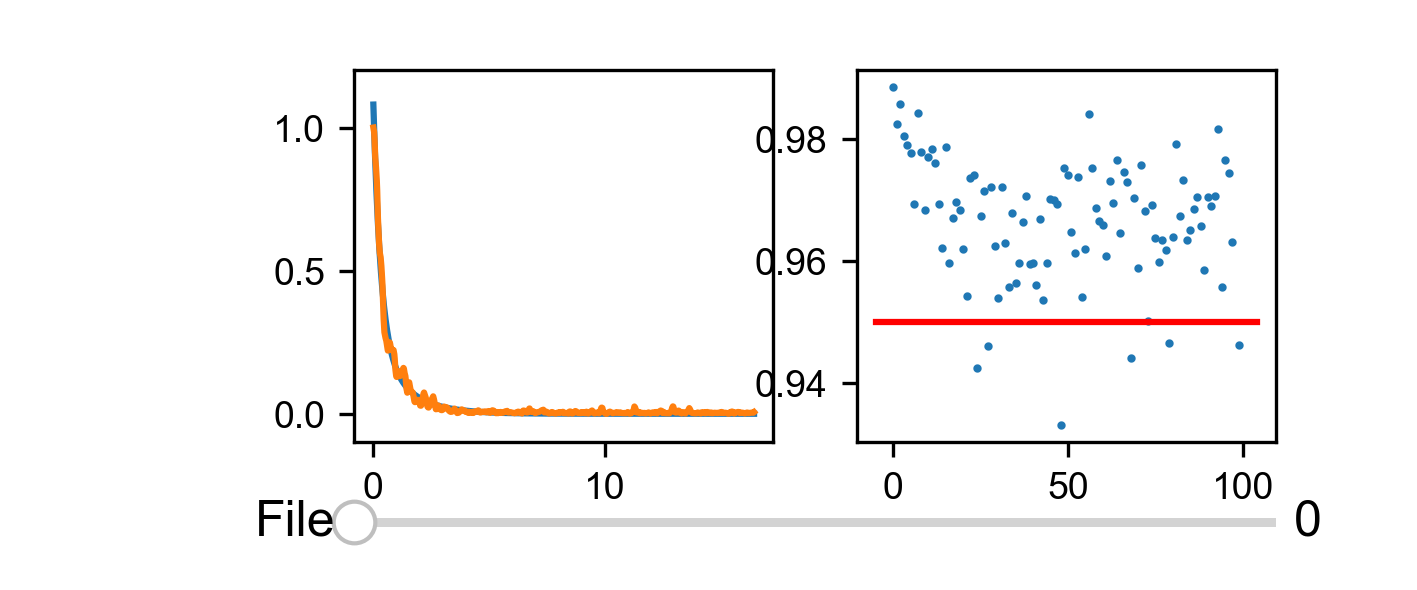

In [ ]:
%matplotlib widget
from matplotlib.widgets import Button, Slider

if 'fig1' in locals():
    try:
        del fig1,ax1,ax2
    except NameError:
        pass


fig1=plt.figure(figsize=(12*cms,5*cms))
ax1 =plt.subplot(1,2,1)
ax2 =plt.subplot(1,2,2)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

line,=ax1.plot(Time_interp,Data_fit_s[0,:])
line2,=ax1.plot(Time_interp,Data_exp_s[0,:])
ax1.set_ylim([-0.1,1.2])

def update(k):
    line.set_ydata(Data_fit_s[int(np.floor(k)),:])
    line2.set_ydata(Data_exp_s[int(np.floor(k)),:])
    fig1.canvas.draw_idle()

fig1.subplots_adjust(left=0.25, bottom=0.25)
axFile = fig1.add_axes([0.25, 0.1, 0.65, 0.03])

file_slider = Slider(
    ax=axFile,
    label="File",
    valmin=0,
    valmax=len(File)-2,
    valinit=0,
    valfmt='%0.0f'
)

file_slider.on_changed(update)
#print(np.linspace(0,len(File[:-1])+1,num=len(File[:-1])+1,dtype='int'))
#ax2.scatter(np.linspace(0,len(File[:-1]),num=len(File[:-1]),dtype='int'),Rsq_Overfit,s=1)
ax2.scatter(np.linspace(0,len(File[:-1]),num=len(File[:-1]),dtype='int'),Rsq_kin,s=1)
ax2.plot(ax2.get_xlim(),[0.95,0.95],color='r')
#plt.show()


<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:33: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Usononis\AppData\Local\Temp\ipykernel_10600\1237488462.py:31: SyntaxWarning: invalid escape sequence '\l'
  ax2.scatter(TimeExp[:-1],WavePeak,s=0.1,label='$\lambda_{p}$',color='blue')
C:\Users\Usononis\AppData\Local\Temp\ipykernel_10600\1237488462.py:33: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_ylabel('$\lambda_{p}$ [nm]')


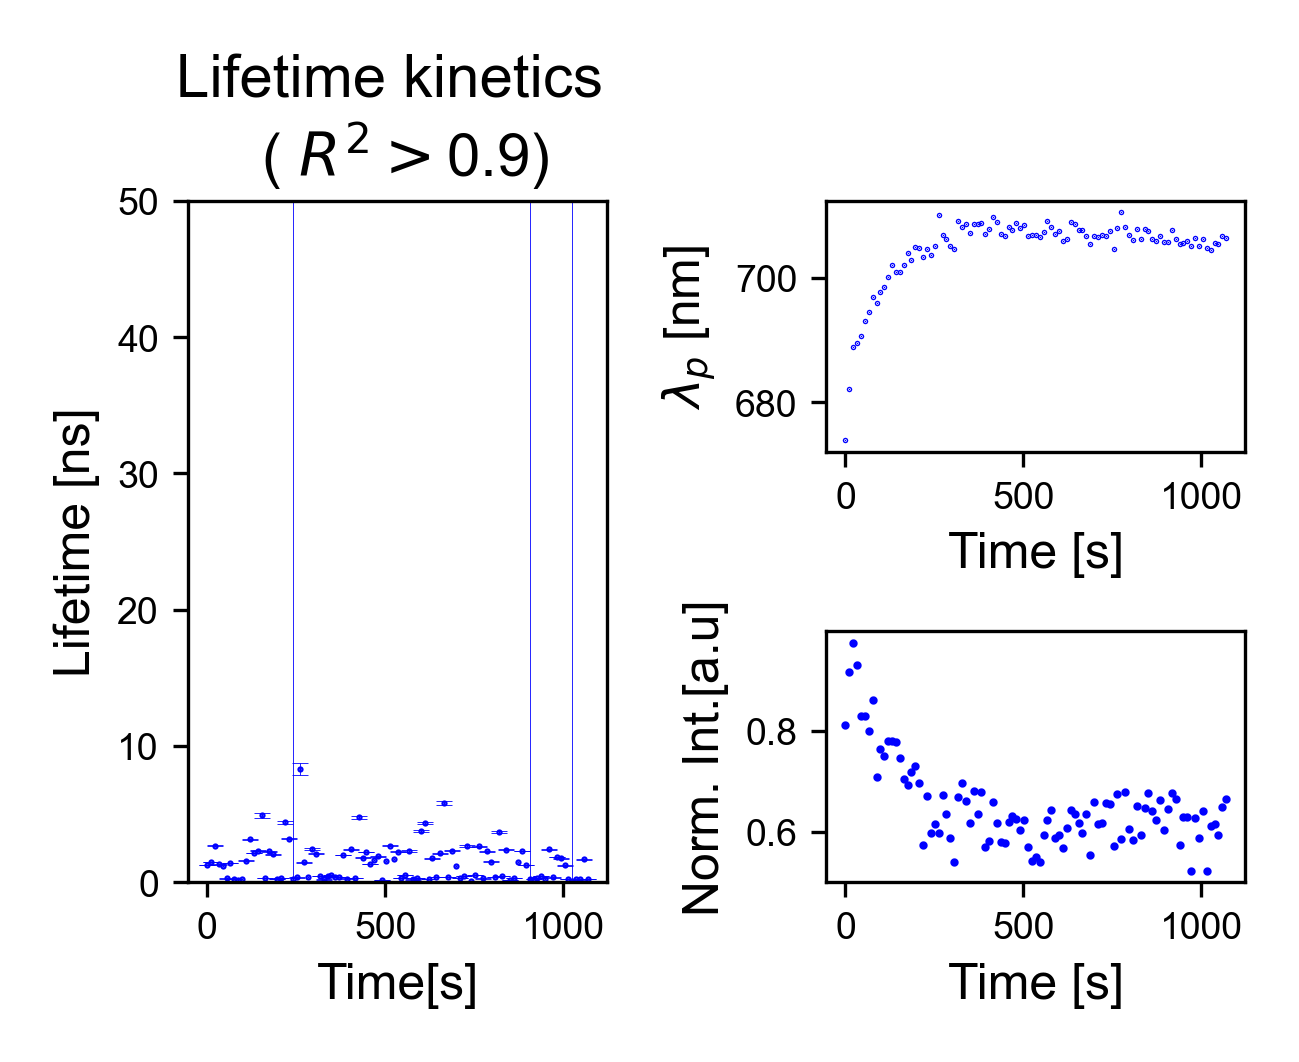

In [ ]:
# We can compute change in dynamics

if 'fig1' in locals():
    try:
        del fig1,ax1,ax2
    except NameError:
        pass


dlp=np.gradient(WavePeak,TimeExp[:-1].squeeze())
dlp2=np.gradient(dlp,TimeExp[:-1].squeeze())
ValueChangeDynamics=TimeExp[np.argmax(dlp)]


fig1 = plt.figure(figsize=(11*cms,9*cms))

ax1= plt.subplot(1,2,1)
ax2= plt.subplot(2,2,2)
ax3= plt.subplot(2,2,4)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})


ax1.errorbar(TimeExp[:-1],LifetimePeak,yerr=ErrorLifetimePeak,capsize=2,fmt='.',color='blue',elinewidth=0.2,capthick=0.2,markersize=1)
ax1.set_ylabel('Lifetime [{}]'.format(TimeUnit[1]))
ax1.set_xlabel('Time[s]')
ax1.set_ylim([0,50])
ax1.set_title('Lifetime kinetics \n ( $R^2>${})'.format(R_value))

ax2.scatter(TimeExp[:-1],WavePeak,s=0.1,label='$\lambda_{p}$',color='blue')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('$\lambda_{p}$ [nm]')

ax3.scatter(TimeExp[:-1],Max_int_Theoritical,s=1,edgecolors='blue',label='$I_{max}$')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Norm. Int.[a.u]',wrap=True)

plt.tight_layout()
plt.savefig("KineticsLifetime.png")


